In [1]:
# Import Libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
# Keras API
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D,Activation,AveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall

In [2]:
train_dir = "train"
test_dir = "test"
val_dir = "val"

In [3]:
# function to get count of images
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count

In [4]:
train_samples =get_files(train_dir)
num_classes=len(glob.glob(train_dir+"/*"))
test_samples=get_files(test_dir) # For testing i took only few samples from unseen data. we can evaluate using validation data which is part of train data.
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

5 Classes
6054 Train images
2025 Test images


In [5]:
# Preprocessing data.
train_datagen=ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   validation_split=0.2, # validation split 20%.
                                   horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)
val_datagen=ImageDataGenerator(rescale=1./255)

In [6]:
# set height and width and color of input image.
img_width,img_height =256,256
input_shape=(img_width,img_height,3)
batch_size =32

train_generator =train_datagen.flow_from_directory(train_dir,
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size)
val_generator=val_datagen.flow_from_directory(val_dir,shuffle=True,
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size)

Found 6054 images belonging to 5 classes.
Found 2025 images belonging to 5 classes.
Found 2016 images belonging to 5 classes.


In [10]:
img_shape=(256,256,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False
    
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(5, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 21124397 (80.58 MB)
Trainable params: 21

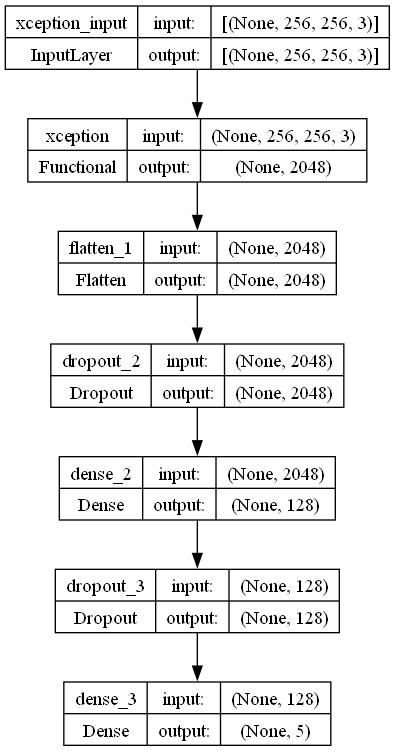

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [12]:
hist = model.fit(train_generator,
                 epochs=10,
                 validation_data=test_generator,
                 shuffle= False)

Epoch 1/10
190/190 [==============================] - 2886s 15s/step - loss: 0.6006 - accuracy: 0.7678 - precision_1: 0.8290 - recall_1: 0.6886 - val_loss: 0.3184 - val_accuracy: 0.8716 - val_precision_1: 0.8812 - val_recall_1: 0.8642
Epoch 2/10
190/190 [==============================] - 1989s 10s/step - loss: 0.3214 - accuracy: 0.8756 - precision_1: 0.8864 - recall_1: 0.8583 - val_loss: 0.3220 - val_accuracy: 0.8756 - val_precision_1: 0.8845 - val_recall_1: 0.8662
Epoch 3/10
190/190 [==============================] - 1565s 8s/step - loss: 0.2657 - accuracy: 0.9001 - precision_1: 0.9059 - recall_1: 0.8905 - val_loss: 0.3631 - val_accuracy: 0.8385 - val_precision_1: 0.8416 - val_recall_1: 0.8316
Epoch 4/10
190/190 [==============================] - 1493s 8s/step - loss: 0.2311 - accuracy: 0.9141 - precision_1: 0.9204 - recall_1: 0.9073 - val_loss: 0.2475 - val_accuracy: 0.9022 - val_precision_1: 0.9071 - val_recall_1: 0.8968
Epoch 5/10
190/190 [==============================] - 1664s 9s

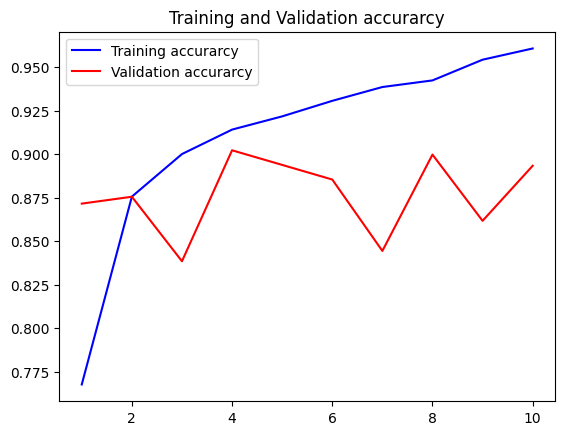

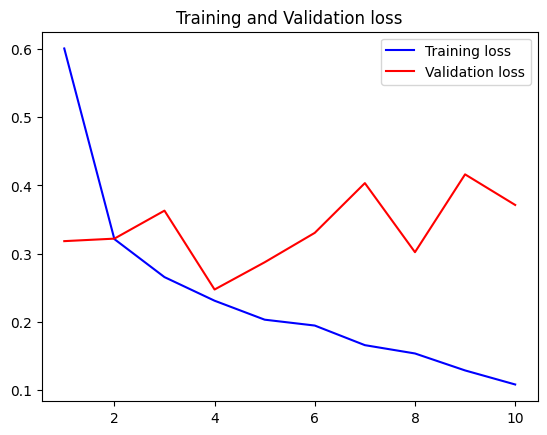

In [16]:
accuracy = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(accuracy) + 1)
#Train and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()